# Introduction to IXPEML

This notebook contains an example run through of the IXPEML pipeline on an example simulated and measured (calibration) dataset.
The example data are contained in Example/data and are in the standard IXPE FITS file format. A 4.51keV calibration file (4p51keV_pol.fits) and a number of simulated data at 4 - 5keV (gen4_4p0.fits,...) are provided.

Check ```requirement.txt``` to install all of the python dependencies (Note this file does not include GPDSW and GPDEXT, these are covered below).

In [2]:
#imports
import sys
import os
sys.path.insert(0, os.path.dirname(os.getcwd())) #set path for imports
import numpy as np
import torch
import subprocess
from util.methods import *
from util.net_test import *
import pickle
from matplotlib import rcParams
# Some plotting style parameters --
rcParams['savefig.dpi']           = 300
rcParams['path.simplify']         = True
rcParams['figure.figsize']        = 4,4
rcParams['font.family']           = "serif"
rcParams['mathtext.fontset']      = "custom"
rcParams['errorbar.capsize']      = 3
rcParams['axes.linewidth']        = 2 
rcParams['font.weight']           = "bold"
rcParams['xtick.major.size']      = 6
rcParams['ytick.major.size']      = 6 
rcParams['xtick.minor.size']      = 3   
rcParams['ytick.minor.size']      = 3
rcParams['xtick.minor.visible']   = True
rcParams['ytick.minor.visible']   = True
rcParams['xtick.direction']      = "in"
rcParams['ytick.direction']      = "in" 
rcParams['xtick.top']      = True
rcParams['ytick.right']      = True 
rcParams['xtick.major.width']     = 1
rcParams['ytick.major.width']     = 1
rcParams['xtick.minor.width']     = 1
rcParams['ytick.minor.width']     = 1
rcParams['lines.markeredgewidth'] = 1
rcParams['legend.numpoints']      = 1
rcParams['legend.frameon']        = False
rcParams['legend.handletextpad']      = 0.3
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# this allows plots to appear directly in the notebook
%matplotlib inline

# Step 1: Raw track reconstruction

Run GPDSW reconstruction on the raw fits files, this step is the same for simulated and real (calibration) data. This requires GPDSW (>= 9.0.0) and GPDEXT software from the [IXPE bitbucket](https://bitbucket.org/ixpesw/workspace/projects/IGS), with a few additions to ```gpdsw/Io/src/ixpeFitsDataFormat.cpp``` and ```gpdsw/Io/src/ixpeLvl1aFitsFile.cpp```

**Please check ```moments/gpdsw/io/...``` contained in this repository to find the additions and update your GPDSW.**

**We do not provide the whole of GPDSW and GPDEXT in this repository, this must be installed independently by the user.**

## Real (calibration) data

In [52]:
#Set up environment variables to run gpdsw
!source ../moments/gpdsw/setup.sh

#Run ixperecon -- This applies moment analysis and saves track images + metadata (e.g. angles, if simulated, energies, 
# absorption points, moments predictions)
#The --write_tracks options is *required* to apply IXPEML
#Threshold 10 must be used for IXPEML v1.2 (current)
!../moments/gpdsw/bin/ixperecon --write-tracks --input-files ~/khome/tracksml/Example/data/4p51keV_pol.fits \
--threshold 10 --output-folder ~/khome/tracksml/Example/data --n 60000


The following have been reloaded with a version change:
  1) python/3.6.1 => python/2.7.13


The following have been reloaded with a version change:
  1) py-numpy/1.17.2_py36 => py-numpy/1.14.3_py27


The following have been reloaded with a version change:
  1) py-scipy/1.1.0_py36 => py-scipy/1.1.0_py27


The following have been reloaded with a version change:
  1) py-numpy/1.14.3_py27 => py-numpy/1.14.3_py36
  2) python/2.7.13 => python/3.6.1


The following have been reloaded with a version change:
  1) py-matplotlib/2.1.2_py36 => py-matplotlib/2.2.2_py27
  2) py-numpy/1.14.3_py36 => py-numpy/1.14.3_py27
  3) python/3.6.1 => python/2.7.13

GPDSWROOT set to  /home/groups/rwr/alpv95/tracksml/Example
PYTHONPATH set to  /home/groups/rwr/alpv95/tracksml/Example:/share/software/user/open/py-matplotlib/2.2.2_py27/lib/python2.7/site-packages:/share/software/user/open/py-numpy/1.14.3_py27/lib/python2.7/site-packages:/share/software/user/open/py-scipy/1.1.0_py27/lib/python2.7/site-packages:/s

## Simulated Data

In [ ]:
#Set up environment variables to run gpdsw
!source ../moments/gpdsw/setup.sh

#Run ixperecon -- This applies moment analysis and saves track images + metadata (e.g. angles, if simulated, energies, 
# absorption points, moments predictions)
!../moments/gpdsw/bin/ixperecon --write-tracks --input-files ~/khome/tracksml/Example/data/gen4_4p[0123456789].fits \
--threshold 10 --output-folder ~/khome/tracksml/Example/data

### Visualizing Hexagonal tracks

Text(0.5,0,'x [mm]')

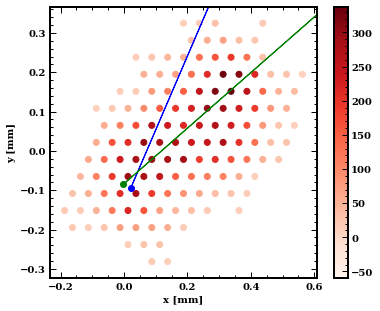

In [2]:
#View simulated hex tracks and their labels:
input_file = "data/gen4_4p9_recon.fits"

with fits.open(input_file, memmap=False) as hdu:
    data = hdu[1].data
with fits.open(input_file.replace('_recon',''), memmap=False) as hdu:
    sim_data = hdu[3].data
    
idx = 5
fig, ax = plt.subplots(figsize=(6,5))

cut = (data['NUM_CLU'] > 0)*(abs(data['BARX']) < 6.3)*(abs(data['BARY']) < 6.3)
cut *= (sim_data['PE_PHI'] != 0.0) #Removes bump in simulated data

moms = (data['TRK_M2L'] / data['TRK_M2T'])[cut]
mom_abs_pts = np.column_stack((data['DETX'],data['DETY']))[cut]
bars = np.column_stack((data['BARX'],data['BARY']))[cut]
abs_pts = np.column_stack((sim_data['ABS_X'],sim_data['ABS_Y']))[cut]
sim_phi = sim_data['PE_PHI'][cut]
mom_phi = data['DETPHI'][cut]

trck = ax.scatter(data['PIX_X'][cut][idx], data['PIX_Y'][cut][idx], c=data['PIX_PHA'][cut][idx], cmap="Reds",vmin=-60)
ax.scatter(abs_pts[idx,0],abs_pts[idx,1],c='b')
ax.scatter(mom_abs_pts[idx,0],mom_abs_pts[idx,1], c='g')
ax.arrow(abs_pts[idx,0],abs_pts[idx,1],10 * np.cos(sim_phi[idx]), 10 * np.sin(sim_phi[idx]),color='b')
ax.arrow(mom_abs_pts[idx,0],mom_abs_pts[idx,1],10 * np.cos(mom_phi[idx]), 10 * np.sin(mom_phi[idx]),color='g')
fig.colorbar(trck)

ax.set_ylabel("y [mm]",fontweight="bold")
ax.set_xlabel("x [mm]",fontweight="bold")

Text(0.5,0,'x [mm]')

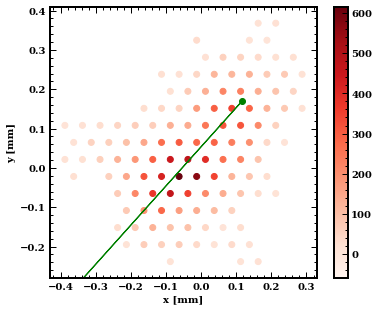

In [9]:
#View real (calibrated) hex tracks and their labels:
input_file = "data/4p51keV_pol_recon.fits"

with fits.open(input_file, memmap=False) as hdu:
    data = hdu[1].data
# with fits.open(input_file.replace('_recon',''), memmap=False) as hdu:
#     sim_data = hdu[3].data
#     print(hdu.info())
    
idx = 5
fig, ax = plt.subplots(figsize=(6,5))

cut = (data['NUM_CLU'] > 0)*(abs(data['BARX']) < 6.3)*(abs(data['BARY']) < 6.3)
#cut *= (sim_data['PE_PHI'] != 0.0)

moms = (data['TRK_M2L'] / data['TRK_M2T'])[cut]
mom_abs_pts = np.column_stack((data['DETX'],data['DETY']))[cut]
bars = np.column_stack((data['BARX'],data['BARY']))[cut]
#abs_pts = np.column_stack((sim_data['ABS_X'],sim_data['ABS_Y']))[cut]
#sim_phi = sim_data['PE_PHI'][cut]
mom_phi = data['DETPHI'][cut]

trck = ax.scatter(data['PIX_X'][cut][idx], data['PIX_Y'][cut][idx], c=data['PIX_PHA'][cut][idx], cmap="Reds",vmin=-60)
#ax.scatter(abs_pts[idx,0],abs_pts[idx,1],c='b')
ax.scatter(mom_abs_pts[idx,0],mom_abs_pts[idx,1], c='g')
#ax.arrow(abs_pts[idx,0],abs_pts[idx,1],10 * np.cos(sim_phi[idx]), 10 * np.sin(sim_phi[idx]),color='b')
ax.arrow(mom_abs_pts[idx,0],mom_abs_pts[idx,1],10 * np.cos(mom_phi[idx]), 10 * np.sin(mom_phi[idx]),color='g')
fig.colorbar(trck)

ax.set_ylabel("y [mm]",fontweight="bold")
ax.set_xlabel("x [mm]",fontweight="bold")

# Step 2: Hexagonal -> Square

Transform the fits files of hexagonal tracks into square tracks for the NNs to use. The final products of this step are directories containing:
* ```tracks_full.pickle``` (Containing sparse representations of square tracks to be read by the NNs)
* ```labels_full.pt``` (Containing all of the track metadata -- angles_simulated, angles_moments, energies, abs_pts_simulated, abs_pts_moments, ...  )

This step is handled by ```run_build_fitsdata.py```, which contains multiple options for designing a simulated or real square dataset from hexagonal fits files.

In [11]:
!python3 ../run_build_fitsdata.py -h

usage: run_build_fitsdata.py [-h] [--augment {1,2,3,4,5,6}] [--shift {1,2}]
                             [--npix {30,50}] [--Erange ERANGE ERANGE]
                             [--fraction FRACTION] [--pl PL] [--aeff]
                             [--meas MEAS] [--meas_tot MEAS_TOT]
                             [--meas_e MEAS_E] [-pulse] [--shuffle]
                             input_base out_base

positional arguments:
  input_base            input folder
  out_base              output folder

optional arguments:
  -h, --help            show this help message and exit
  --augment {1,2,3,4,5,6}
                        Number of Track augmentation randomly distributed in
                        dataset. These should always be 3 during inference for
                        >= v1.1
  --shift {1,2}         Number of Track shifts randomly distributed in
                        dataset. This should always be 2 for >= v1.1
  --npix {30,50}        Number of pixels in square conversions. This sho

## Make simulated square dataset

In [12]:
#Simulated Tracks
!python3 ../run_build_fitsdata.py ~/khome/tracksml/Example/data/ ~/khome/tracksml/Example/data/sim \
    --Erange 4.0 5.0 --fraction 0.005 --pl 0 --shuffle


out_base:  /home/users/alpv95/khome/tracksml/Example/data/sim
Directory Created for Simulated data
Total number of unique tracks = 153500

Building dataset for gen4 4.0 keV None deg sim
39750 loaded ok
Beginning parallelization on 32 cores

DONE!
torch.Size([15350, 3])
Finished 

15350 15350
(3, 2, 3, 72)
torch.Size([153500, 3])
Building dataset for gen4 4.1 keV None deg sim
39779 loaded ok
Beginning parallelization on 32 cores

DONE!
torch.Size([15350, 3])
Finished 

30700 30700
(3, 2, 3, 90)
torch.Size([153500, 3])
Building dataset for gen4 4.2 keV None deg sim
39733 loaded ok
Beginning parallelization on 32 cores

DONE!
torch.Size([15350, 3])
Finished 

46050 46050
(3, 2, 3, 98)
torch.Size([153500, 3])
Building dataset for gen4 4.3 keV None deg sim
39754 loaded ok
Beginning parallelization on 32 cores

DONE!
torch.Size([15350, 3])
Finished 

61400 61400
(3, 2, 3, 76)
torch.Size([153500, 3])
Building dataset for gen4 4.4 keV None deg sim
39755 loaded ok
Beginning parallelization on 3

In [10]:
#Measured (calibration) data 
#use --meas flags:
!python3 ../run_build_fitsdata.py ~/khome/tracksml/Example/data/ ~/khome/tracksml/Example/data/ \
    --meas 4p51keV_pol_recon.fits --meas_tot 40000 --meas_e 4.5

out_base:  /home/users/alpv95/khome/tracksml/Example/data/
Total number of unique tracks to square = 40000

Building dataset for gen4 4.5 keV None deg meas
59950 loaded ok
Directory already exists
Beginning parallelization on 20 cores

DONE!
torch.Size([40000])
Finished 

Saved,  /home/users/alpv95/khome/tracksml/Example/data/meas_4p5_None_pol/train/ /home/users/alpv95/khome/tracksml/Example/data/meas_4p5_None_pol/test/


## Visualize Square Tracks

These are what the NNs see.

### Simulated

In [13]:
#Sparse Square tracks
with open("data/sim/train/tracks_full.pickle", "rb") as file:
    sparse_tracks = pickle.load(file)

#Tracks metadata
angles_sim, moms, angles_mom, abs_pts_sim, mom_abs_pts, energies_sim, xy_abs_mom = torch.load("data/sim/train/labels_full.pt")
#moms, angles_mom, mom_abs_pts, energies_sim, xy_abs_sim = torch.load("data/train/labels_full.pt")

#Convert sparse to dense for plotting
dense_tracks = sparse2dense(sparse_tracks)

Text(0.5,0,'x')

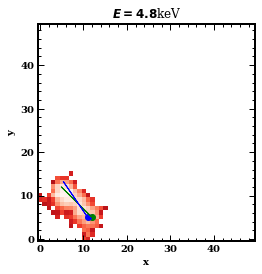

In [19]:
#Choose track to plot
idx = 61

fig, ax = plt.subplots()
ax.imshow(dense_tracks[idx], norm=LogNorm(vmin=5,vmax=600),origin='lower', cmap="Reds_r")
ax.scatter(mom_abs_pts.numpy()[idx,0,0,0],mom_abs_pts.numpy()[idx,0,0,1], c='g')
ax.arrow(mom_abs_pts.numpy()[idx,0,0,0],mom_abs_pts.numpy()[idx,0,0,1],10 * np.cos(angles_mom[idx,0]), 10 * np.sin(angles_mom[idx,0]),color='g')
ax.scatter(abs_pts_sim.numpy()[idx,0,0,0],abs_pts_sim.numpy()[idx,0,0,1], c='b')
ax.arrow(abs_pts_sim.numpy()[idx,0,0,0],abs_pts_sim.numpy()[idx,0,0,1],10 * np.cos(angles_sim[idx,0]), 10 * np.sin(angles_sim[idx,0]),color='b')

ax.set_title(r"$E = {:.2}$keV".format(energies_sim[idx,0]))
ax.set_ylabel("y",fontweight="bold")
ax.set_xlabel("x",fontweight="bold")

Green == Moment Analysis predicted absorption point and angle

Blue == True (Simulated) absorption point and angle

### Real (calibrated)

In [20]:
#Sparse Square tracks
with open("data/meas_4p5_None_pol/train/tracks_full.pickle", "rb") as file:
    sparse_tracks = pickle.load(file)

#Tracks metadata
moms, angles_mom, mom_abs_pts, energies_sim, xy_abs_mom = torch.load("data/meas_4p5_None_pol/train/labels_full.pt")

#Convert sparse to dense for plotting
dense_tracks = sparse2dense(sparse_tracks)

Text(0.5,0,'x')

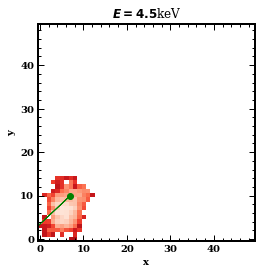

In [21]:
idx = 40
fig, ax = plt.subplots()
ax.imshow(dense_tracks[idx], norm=LogNorm(vmin=5,vmax=600),origin='lower', cmap="Reds_r")
ax.scatter(mom_abs_pts.numpy()[idx,0,0,0],mom_abs_pts.numpy()[idx,0,0,1], c='g')
ax.arrow(mom_abs_pts.numpy()[idx,0,0,0],mom_abs_pts.numpy()[idx,0,0,1],10 * np.cos(angles_mom[idx,0]), 10 * np.sin(angles_mom[idx,0]),color='g')
ax.set_title(r"$E = {:.2}$keV".format(energies_sim[idx,0]))
ax.set_ylabel("y",fontweight="bold")
ax.set_xlabel("x",fontweight="bold")

Green (Moment analysis) only now, because real (calibration) data does not come with true angles and absorption points

# Step 3: Deep Ensemble

Run square track datasets through the deep ensemble of NNs. **This requires a GPU available (the more the merrier).**
This step is run with ```gpu_test.py```; the results are saved in a pickle file specified with the ```--save``` flag.
Stick to the options flags shown in the examples, some options (like ```--stokes_correct```) are not fully complete. 

The only difference between simulated and measured data is the ```---datatype``` flag.

In [23]:
!python3 ../gpu_test.py -h

usage: gpu_test.py [-h] [--ensemble {pol_only,pol_abs_E,bigE}] [--plot]
                   [--bayes] [--cut CUT] [--save SAVE] [--method METHOD]
                   [--model_list MODEL_LIST [MODEL_LIST ...]]
                   [--data_list DATA_LIST [DATA_LIST ...]]
                   [--datatype {sim,meas}] [--input_channels INPUT_CHANNELS]
                   [--stokes_correct {2.0,2.3,2.7,3.1,3.7,5.9}]

optional arguments:
  -h, --help            show this help message and exit
  --ensemble {pol_only,pol_abs_E,bigE}
                        Which network ensemble to use: Ensemble prediction or
                        single prediction
  --plot                Whether to plot histograms and modulation curves
  --bayes               Whether to sample from dropout
  --cut CUT             What proportion of tracks to leave after ellipticity
                        cut
  --save SAVE           Save Net FoV results in Pandas dataframe with this
                        name
  --method METHOD   

### Simulated Data

In [ ]:
#Step 2:
#Run tracks through deep ensemble (requires GPU available)
print("Number of GPUs available: {}\n".format(torch.cuda.device_count()))

!python3 ../gpu_test.py --data_list Example/data/train/ --ensemble bigE --save kev4_5

Number of GPUs available: 1

Evaluating using ensemble: 
 ['733_mserrall1_2/models/mom_1024_151.ptmodel', '733_mserrall1_2/models/mom_2048_131.ptmodel', '733_mserrall1_2/models/RLRP_1024_151.ptmodel', '733_mserrall1/models/mom_2048_121.ptmodel', '733_mserrall1/models/mom_2048_51.ptmodel', '733_mserrall1_2/models/mom_2048_71.ptmodel', '733_mserrall1/models/mom_512_81.ptmodel', '733_mserrall1_2/models/RLRP_1024_71.ptmodel', '733_mserrall1/models/mom_1024_101.ptmodel', '733_mserrall1_2/models/mom_512_111.ptmodel']

 10 NNs in the ensemble 

>> NN 1/10 : 

Loading full dataset into memory

Dataset size:  torch.Size([138150, 3])
Evaluating on GPU 

>> Complete
>> NN 2/10 : 

Loading full dataset into memory

Dataset size:  torch.Size([138150, 3])
Evaluating on GPU 

>> Complete
>> NN 3/10 : 

Loading full dataset into memory

Dataset size:  torch.Size([138150, 3])
Evaluating on GPU 

>> Complete
>> NN 4/10 : 

Loading full dataset into memory

Dataset size:  torch.Size([138150, 3])
Evaluati

### Measured Data

In [3]:
#Step 2:
#Run tracks through deep ensemble (requires GPU available)
print("Number of GPUs available: {}\n".format(torch.cuda.device_count()))

!python3 ../gpu_test.py --data_list Example/data/meas_4p5_None_pol/train/ --ensemble bigE --save kev4_5 --datatype meas

Number of GPUs available: 1

Evaluating using ensemble: 
 ['733_mserrall1_2/models/mom_1024_151.ptmodel', '733_mserrall1_2/models/mom_2048_131.ptmodel', '733_mserrall1_2/models/RLRP_1024_151.ptmodel', '733_mserrall1/models/mom_2048_121.ptmodel', '733_mserrall1/models/mom_2048_51.ptmodel', '733_mserrall1_2/models/mom_2048_71.ptmodel', '733_mserrall1/models/mom_512_81.ptmodel', '733_mserrall1_2/models/RLRP_1024_71.ptmodel', '733_mserrall1/models/mom_1024_101.ptmodel', '733_mserrall1_2/models/mom_512_111.ptmodel']

 10 NNs in the ensemble 

>> NN 1/10 : 

Loading full dataset into memory

Dataset size:  torch.Size([36000, 3])


# Step 4: Analyze results / Postprocess

Full results from the deep ensembles and moment analysis are saved in a single pickle file in Step 1 (the track images themselves, if desired, still have to be extracted from the fits/pt files as in Step 1 visualization).

The final results for simulated and measured tracks are:
* angles_nn -- NN predicted photoelectron angles, numpy array of floats shape (N, 3, n) --> **N is the number of tracks**, 3 120deg rotations to remove hex2square bias, and **n the number of NNs in the ensemble (~10)**
* angles_mom -- Moment analysis predicted photoelectron angles, numpy array of floats shape (N) 
* angles_sim -- True photoelectron angles (if data is simulated, otherwise this is None), numpy array of floats shape (N) 
* ellipticities -- Moment analysis measured track ellipticies, numpy array of floats shape (N) 
* errors -- NN predicted uncertainties (sigmas) on photoelectron angles, numpy array of floats shape (N, 3, n)
* abs_pts_nn -- NN predicted absorption points (xy coords on the square track image grid 30x30), numpy array of floats shape (N, 3, 2, n)
* mom_abs_pts -- Moments predicted absorption points (xy coords on the square track image grid 30x30), numpy array of floats shape (N, 2)
* abs_pts_sim -- True absorption points (xy coords on the square track image grid 30x30) (if data is simulated, otherwise this is None), numpy array of floats shape (N, 2)
* energies_nn -- NN predicted track energies in keV, numpy array of floats shape (N) (These have already been averaged across n and 3)
* energies_sim -- True track energies in keV (if data is simulated, otherwise this is None), numpy array of floats shape (N)
* angles1 -- Diagnostic/testing Tool (ignore)
* errors1 -- Diagnostic/testing Tool (ignore)
* xy_abs_mom -- Moments predicted absorption points (xy coords on the detector grid), numpy array of floats shape (N, 2). These are to convert from abs_pts on the NN track image grid to detector abs_pts.


## Loading results for analysis

In [ ]:
#This is the pickle file containing the final results (simulated)
with open("../tracksml_Example_data_train___kev4_5__ensemble.pickle", "rb") as file:
    A = pickle.load(file)
    
angles_NN, angles_mom, angles_sim, moms, errors, abs_pts, mom_abs_pts, abs_pts_sim, \
energies, energies_sim, _, _, xy_abs_mom = A

#Find NN predicted abs pts on hexagonal detector grid
xy_abs_nn = square2hex_abs(abs_pts, mom_abs_pts, xy_abs_mom)

In [36]:
#This is the pickle file containing the final results (measured)
with open("../_Example_data_meas_4p5_None_pol_test___kev4_5__ensemble.pickle", "rb") as file:
    A = pickle.load(file)
    
angles_NN_meas, angles_mom_meas, _, moms_meas, errors_meas, abs_pts_meas, mom_abs_pts_meas, _, \
energies_meas, _, _, _, xy_abs_mom_meas = A #For measured tracks, _sim outputs are None so we ignore these.

#Find NN predicted abs pts on hexagonal detector grid
xy_abs_nn_meas = square2hex_abs(abs_pts_meas, mom_abs_pts_meas, xy_abs_mom_meas)

## Analyse polarization results with simple Stokes' analysis (Measured data)

```util/net_test.py``` contains the majority of our polarization analysis functions, including Stokes parameters and weighted maximum likelihood estimation. These are called by instantiated a ```NetTest``` class, as below. The ellipticity cut fraction, fitting method and other parameters can be set in this class. 

Method: stokes



Text(0,0.5,'Normalized Counts')

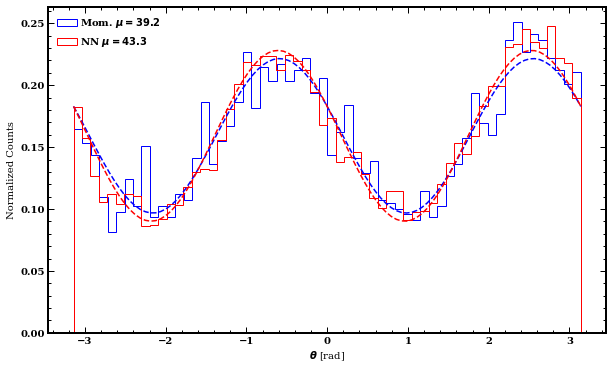

In [41]:
#Instantiate NetTest
t = NetTest(n_nets=10) #Number of NNs in the ensemble for error estimates, for this v1.2 should always be 10

pol_input = (angles_NN_meas, angles_mom_meas, [None], moms_meas, errors_meas)
#Calculate modulation factors and EVPAs and their errors using standard Stokes' method.
mu, phi0, mu_err, phi0_err = t.fit_mod(pol_input, method='stokes')

mu_NN, mu_mom, = mu
phi_NN, phi_mom, = phi0


#Plot:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(angles_mom_meas, bins=60, density=True, label=r"Mom. $\mu = {:.3}$".format(mu_mom*100),color="b",histtype="step")
ax.hist(np.ndarray.flatten(angles_NN_meas), bins=60, density=True, label="NN $\mu = {:.3}$".format(mu_NN*100),color="r",histtype="step")

ax.plot(np.linspace(-np.pi,np.pi,100), (1/(2*np.pi))* (1 + mu_mom*np.cos(2*(np.linspace(-np.pi,np.pi,100) - phi_mom))), "b--")
ax.plot(np.linspace(-np.pi,np.pi,100), (1/(2*np.pi))* (1 + mu_NN*np.cos(2*(np.linspace(-np.pi,np.pi,100) - phi_NN))), "r--")

ax.legend()
ax.set_xlabel(r"$\theta$ [rad]")
ax.set_ylabel(r"Normalized Counts")

## Analyse polarization results with simple Stokes' analysis (Simulated data)

Method: stokes



Text(0,0.5,'Normalized Counts')

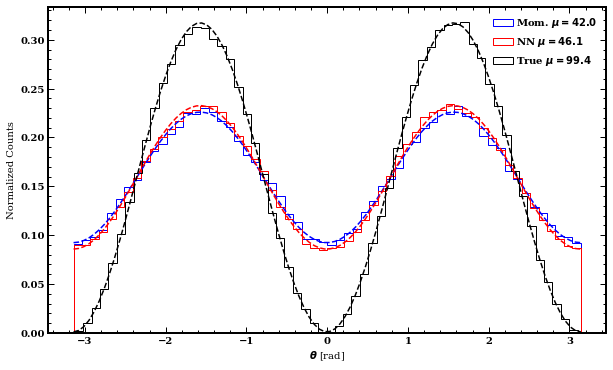

In [42]:
#Instantiate NetTest
t = NetTest(n_nets=10) #Number of NNs in the ensemble for error estimates, for this v1.2 should always be 10

pol_input = (angles_NN, angles_mom, angles_sim, moms, errors)
#Calculate modulation factors and EVPAs and their errors using standard Stokes' method.
mu, phi0, mu_err, phi0_err = t.fit_mod(pol_input, method='stokes')

mu_NN, mu_mom, mu_sim = mu
phi_NN, phi_mom, phi_sim = phi0

#Plot:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(angles_mom, bins=60, density=True, label=r"Mom. $\mu = {:.3}$".format(mu_mom*100),color="b",histtype="step")
ax.hist(np.ndarray.flatten(angles_NN), bins=60, density=True, label="NN $\mu = {:.3}$".format(mu_NN*100),color="r",histtype="step")
ax.hist(angles_sim, bins=60, density=True, label="True $\mu = {:.3}$".format(mu_sim*100),color="k",histtype="step")

ax.plot(np.linspace(-np.pi,np.pi,100), (1/(2*np.pi))* (1 + mu_mom*np.cos(2*(np.linspace(-np.pi,np.pi,100) - phi_mom))), "b--")
ax.plot(np.linspace(-np.pi,np.pi,100), (1/(2*np.pi))* (1 + mu_NN*np.cos(2*(np.linspace(-np.pi,np.pi,100) - phi_NN))), "r--")
ax.plot(np.linspace(-np.pi,np.pi,100), (1/(2*np.pi))* (1 + mu_sim*np.cos(2*(np.linspace(-np.pi,np.pi,100) - phi_sim))), "k--")

ax.legend()
ax.set_xlabel(r"$\theta$ [rad]")
ax.set_ylabel(r"Normalized Counts")

# Weighted/Ellipticity Cut Analysis

Method: weighted_MLE



/home/groups/rwr/alpv95/tracksml/util/net_test.py:266: RuntimeWarning: invalid value encountered in log
  loglike_ipopt = lambda x: -np.sum((1 / error**error_weight) * np.log(1 + cs@x))


Moment cut at 1.42, leaving 0.811 of dataset

Moment cut at 1.42, leaving 0.811 of dataset



Text(0,0.5,'Normalized Counts')

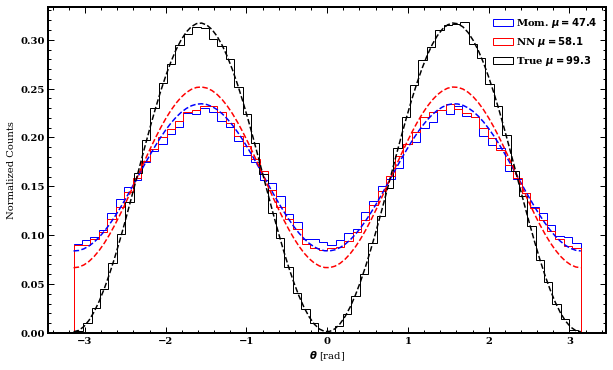

In [43]:
t = NetTest(n_nets=10)

#Can also filter by (true or predicted) energy
e1 = 4.1
e2 = 4.5
cut = (energies_sim >= e1) * (energies_sim <= e2) 
angles_NN_e = angles_NN[cut]
angles_sim_e = angles_sim[cut]
angles_mom_e = angles_mom[cut]
errors_e = errors[cut]
moms_e = moms[cut]

pol_input = (angles_NN_e, angles_mom_e, angles_sim_e, moms_e, errors_e)
#Calculate modulation factors and EVPAs and their errors using weighted maximum likelihood estimation with
# lambda = 2 (the weighting parameter, see paper).
#For the Moment analysis angles, this applies an ellipticity cut.
mu, phi0, mu_err, phi0_err = t.fit_mod(pol_input, method='weighted_MLE', error_weight=2)

mu_NN, mu_mom, mu_sim = mu
phi_NN, phi_mom, phi_sim = phi0

#Plot:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(angles_mom, bins=60, density=True, label=r"Mom. $\mu = {:.3}$".format(mu_mom*100),color="b",histtype="step")
ax.hist(np.ndarray.flatten(angles_NN), bins=60, density=True, label="NN $\mu = {:.3}$".format(mu_NN*100),color="r",histtype="step")
ax.hist(angles_sim, bins=60, density=True, label="True $\mu = {:.3}$".format(mu_sim*100),color="k",histtype="step")

ax.plot(np.linspace(-np.pi,np.pi,100), (1/(2*np.pi))* (1 + mu_mom*np.cos(2*(np.linspace(-np.pi,np.pi,100) - phi_mom))), "b--")
ax.plot(np.linspace(-np.pi,np.pi,100), (1/(2*np.pi))* (1 + mu_NN*np.cos(2*(np.linspace(-np.pi,np.pi,100) - phi_NN))), "r--")
ax.plot(np.linspace(-np.pi,np.pi,100), (1/(2*np.pi))* (1 + mu_sim*np.cos(2*(np.linspace(-np.pi,np.pi,100) - phi_sim))), "k--")

ax.legend()
ax.set_xlabel(r"$\theta$ [rad]")
ax.set_ylabel(r"Normalized Counts")

## Plot predicted absorption points on detector grid (Measured)

Text(0.5,0,'y')

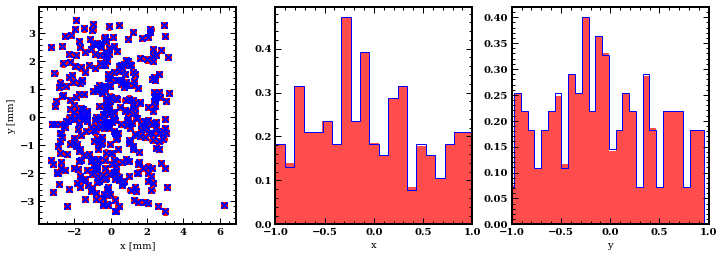

In [48]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4), ncols=3)
ax1.scatter(xy_abs_nn_meas[:,0],xy_abs_nn_meas[:,1],c="r") #NNs
ax1.scatter(xy_abs_mom_meas[:,0],xy_abs_mom_meas[:,1],c="b",marker="x",alpha=0.7) #Moment Analysis

# ax1.set_xlim(-1,1)
# ax1.set_ylim(-1,1)
ax1.set_xlabel("x [mm]")
ax1.set_ylabel("y [mm]")

ax2.hist(xy_abs_nn_meas[:,0],bins=100,density=True, color="r",alpha=0.7)
ax2.hist(xy_abs_mom_meas[:,0],bins=100,density=True, color="b", histtype="step")
ax2.set_xlim(-1,1)
ax2.set_xlabel("x")

ax3.hist(xy_abs_nn_meas[:,1],bins=100,density=True, color="r",alpha=0.7)
ax3.hist(xy_abs_mom_meas[:,1],bins=100,density=True, color="b", histtype="step")
ax3.set_xlim(-1,1)
ax3.set_xlabel("y")


## Plot Energy resolution (Simulated)

Text(0,0.5,'Normalized Counts')

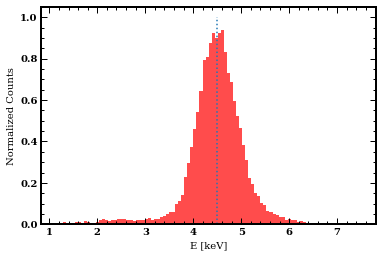

In [51]:
#Plot Energy Resolution
beta_ls = np.array([0.00029483, 0.05735115])

#Can select by true energy when data is simulated
e = 4.5
cut_nn = (energies_sim == e)
fig, ax = plt.subplots()
ax.plot([e,e],[0,1.0],":")
ax.hist(energies[cut_nn], bins=100, density=True,alpha=0.7, color='r')
ax.set_xlabel("E [keV]")
ax.set_ylabel("Normalized Counts")